In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import silhouette_score
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer

# Functions

In [2]:
def load_dataset(file_path):
    return pd.read_pickle(file_path)

In [3]:
def drop_nan_rows(df, column):
    df = df.dropna(subset=[column])
    df = df[df[column] != "nan"]
    df = df[df[column] != ""]
    return df

In [4]:
def create_embedding_matrix(df, column):
    embedding_matrix = np.vstack(df[column].values)
    return embedding_matrix

In [5]:
def tsne_transform(
    df, embedding_matrix, perplexity=17, max_iter=10000, random_state=42
):
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        max_iter=max_iter,
        random_state=random_state,
    )
    embeddings_2d = tsne.fit_transform(embedding_matrix)
    df = df.copy()
    df.loc[:, "tsne_x"] = embeddings_2d[:, 0]
    df.loc[:, "tsne_y"] = embeddings_2d[:, 1]
    return df, embeddings_2d

In [6]:
def generate_kmeans_clusters(df, embedding_matrix, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=10000, random_state=42)
    df["cluster"] = kmeans.fit_predict(embedding_matrix)
    return df

In [7]:
nltk.download("stopwords", quiet=True)

# Load Portuguese stopwords
portuguese_stopwords = stopwords.words("portuguese")
additional_stopwords = [
    "pra",
    "pro",
    "tá",
    "já",
    "ter",
    "vai",
    "vou",
    "então",
    "assim",
    "aí",
    "sobre",
    "porque",
    "como",
    "quando",
    "onde",
    "quem",
    "qual",
    "que",
    "isso",
    "isto",
    "aquilo",
    "pq"
]
portuguese_stopwords.extend(additional_stopwords)

In [8]:
def get_cluster_words(df_preprocessed, column):
    cluster_top_terms = {}
    clusters = sorted(df_preprocessed["cluster"].unique())

    # Step 1: One document per cluster
    cluster_docs = [
        " ".join(df_preprocessed[df_preprocessed["cluster"] == c][column].tolist())
        for c in clusters
    ]

    # Step 2: Compute c-TF-IDF matrix
    vectorizer = CountVectorizer(stop_words=portuguese_stopwords, min_df=3, ngram_range=(1, 2))
    X = vectorizer.fit_transform(cluster_docs)
    tf = X.multiply(1 / X.sum(axis=1))  # normalize term frequency
    idf = np.log(len(df_preprocessed) / (X > 0).sum(axis=0))  # inverse doc freq
    ctfidf_matrix = tf.multiply(idf)  # class-based TF-IDF

    ctfidf_matrix = ctfidf_matrix.tocsr()
    feature_names = vectorizer.get_feature_names_out()

    # Step 3: For each cluster, get top terms
    for idx, c in enumerate(clusters):
        row = np.asarray(ctfidf_matrix[idx].todense()).flatten()  # force 1D dense
        top_indices = row.argsort()[::-1][:20]
        top_terms = [(feature_names[i], row[i]) for i in top_indices]
        cluster_top_terms[c] = top_terms
        print(f"\nCluster {c}:")
        print([term for term, _ in top_terms])

    return cluster_top_terms

In [9]:
def get_wordcloud(cluster_top_terms):
    combined_word_freq = {}
    for c, terms in cluster_top_terms.items():
        for term, score in terms:
            if term in combined_word_freq:
                combined_word_freq[term] += score
            else:
                combined_word_freq[term] = score

    wc = WordCloud(
        width=1200, height=800, background_color="white"
    ).generate_from_frequencies(combined_word_freq)
    plt.figure(figsize=(15, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Combined Word Cloud for All Clusters")
    plt.show()

In [10]:
def visualize_clusters(df, n_clusters=5):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df,
        x="tsne_x",
        y="tsne_y",
        hue="cluster",
        palette="tab20",
        legend=None,
        s=40,
    )
    plt.title("t-SNE visualization of clusters")
    plt.show()

In [11]:
def run_workflow(df, df_preprocessed, column, n_clusters=5):
    print(f"DF shape: {df.shape}")
    embedding_matrix = create_embedding_matrix(df, f"{column}_embedding")
    df, embeddings_2d = tsne_transform(df, embedding_matrix)
    df = generate_kmeans_clusters(df, embedding_matrix, n_clusters)

    df_preprocessed = df_preprocessed.copy()
    df_preprocessed["cluster"] = df.loc[df_preprocessed.index, "cluster"]

    cluster_top_terms = get_cluster_words(df_preprocessed, column)
    get_wordcloud(cluster_top_terms)
    visualize_clusters(df, n_clusters)

In [12]:
def all_status_workflow(df, df_preprocessed, column, n_clusters=5):
    run_workflow(df, df_preprocessed, column, n_clusters=n_clusters)

# Define Files

In [13]:
file_path = "../../data/adhd-beliefs-pt/adhd-beliefs-pt-embeddings-serafim.pkl"
column = "merged_text"

In [14]:
df = load_dataset(file_path)
df = drop_nan_rows(df, column)
df

,datetime,sex,adhd_diagnosis,age,education,occupation,dialect,forgetting_objects,forgetting_responsabilities,emotion_management,...,special_interest,diary_entry,selfdefining_memory,empty_sheet,merged_text,special_interest_embedding,diary_entry_embedding,selfdefining_memory_embedding,empty_sheet_embedding,merged_text_embedding
1,2025-03-30T16:29:47+02:00,Feminino,Não tenho,22,Licenciatura,Estudante,Português de Portugal,3,3,4,...,"Adoro cozinhar, porque sinto que é a forma ide...","Hoje foi um dia bastante normal, como ontem fi...","Quando era mais nova, eu tinha uma professora ...",Recentemente tenho pensado muito no impacto qu...,"Adoro cozinhar, porque sinto que é a forma ide...","[-0.0066892994, -0.008711162, 0.020823173, -0....","[0.01390781, -0.02137232, 0.0012341079, 0.0150...","[-0.00776063, -0.025320444, 0.0047106496, 0.05...","[0.006371905, -0.025407678, 0.009668698, 0.000...","[-0.0029476678, -0.011171358, 0.018170422, -0...."
3,2025-03-31T12:08:00+02:00,Feminino,Não tenho,23,Mestrado,Trabalhador-estudante,Português de Portugal,2,1,4,...,Gosto de ver séries porque relatam relações sa...,Os eventos que considero mais relevantes serão...,Não tenho,Este questionário foi um pouco extenso. Meu au...,Gosto de ver séries porque relatam relações sa...,"[0.011201556, -0.016555935, 0.055444784, 0.028...","[-0.003650666, -0.03267713, 0.042604044, 0.004...","[-0.023299124, -0.00144792, 0.0193926, 0.02227...","[-0.01334663, -0.007554374, -0.023176813, 0.01...","[0.02298963, -0.03627958, 0.063108824, 0.02827..."
6,2025-03-31T12:27:51+02:00,Feminino,Não tenho,20,Ensino secundário,Estudante,Português de Portugal,3,2,4,...,NaN,Ao longo de 7 anos nunca esperei acabar uma am...,NaN,NaN,Ao longo de 7 anos nunca esperei acabar uma am...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.021967987, -0.016598742, 0.048582874, 0.04...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.021967987, -0.016598742, 0.048582874, 0.04..."
8,2025-03-31T12:55:43+02:00,Feminino,Não tenho,19,Licenciatura,Estudante,Português de Portugal,3,2,2,...,Campos de ferias. Temos que criar o campo todo...,"O meu dia? Dormi 3h, somehow consegui acordar ...",NaN,NaN,Campos de ferias. Temos que criar o campo todo...,"[-0.010825634, -0.02388897, -0.013832388, -0.0...","[0.002428587, -0.015170264, 0.0040846155, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.010825634, -0.02388897, -0.013832388, -0.0..."
14,2025-03-31T13:54:40+02:00,Feminino,Não tenho,25,Mestrado,Trabalhador,Português de Portugal,4,3,4,...,"Taylor Swift, amo o seu liricismo e a maneira ...",NaN,Talvez a minha memória mais formativa tenha si...,Pah... not to be political mas estamos a camin...,"Taylor Swift, amo o seu liricismo e a maneira ...","[-0.029966783, -0.030345816, 0.014844258, 0.01...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.009094046, -0.013644675, 0.016085394, -0.00...","[-0.0014996869, -0.0001300723, 0.016133873, 0....","[-0.018019866, -0.03030211, 0.009025991, 0.007..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,2025-06-11T00:05:05+02:00,Feminino,Não tenho,23,Licenciatura,Estudante,Português de Portugal,3,4,5,...,Gosto de nadar e de estar em contacto com a ág...,NaN,NaN,NaN,Gosto de nadar e de estar em contacto com a ág...,"[0.0095119085, -0.0115469545, -0.028541785, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0095119085, -0.0115469545, -0.028541785, -0..."
315,2025-06-11T00:08:08+02:00,Masculino,"Sim, diagnosticado",20,Ensino secundário,Estudante,Português de Portugal,4,2,4,...,Literatura dos séculos XIX e XX. Há imensas hi...,Provavelmente tentar ler e não conseguir. Tent...,Não vou entrar em detalhes por ser um assunto ...,NaN,Literatura dos séculos XIX e XX. Há imensa

## Women with ADHD vs. Others

In [15]:
mask_women_adhd = (df['sex']=="Feminino") & (df['adhd_diagnosis']=="Sim, diagnosticado")
mask_others = ~mask_women_adhd

df_women_adhd = df[mask_women_adhd]
df_others = df[mask_others]

DF shape: (23, 67)

Cluster 0:
['pessoas', 'vida', 'falar', 'vezes', 'trabalho', 'mim', 'nada', 'toda', 'comigo', 'acho', 'mundo', 'sei', 'memória', 'tão', 'sempre', 'bem', 'pessoa', 'tudo', 'especial', 'medo']

Cluster 1:
['percebi', 'hoje', 'tão', 'ainda', 'ajuda', 'dia', 'tudo', 'mesma', 'mundo', 'especial', 'falar', 'acho', 'difícil', 'menos', 'mim', 'nunca', 'vida', 'fazer', 'acordei', 'sei']

Cluster 2:
['pessoas', 'cansada', 'continuam', 'saúde', 'almoço', 'vão', 'bem', 'vez', 'trabalhar', 'cada vez', 'dentro', 'difícil', 'cada', 'porquê', 'percebi', 'medo', 'pergunta', 'nada', 'mim', 'ir']

Cluster 3:
['ainda', 'fazer', 'dia', 'vida', 'nunca', 'comigo', 'bem', 'sempre', 'sei', 'hoje', 'pessoas', 'adoro', 'acho', 'tudo', 'anos', 'mim', 'uns', 'tempo', 'ver', 'menos']

Cluster 4:
['hoje', 'phda', 'adoro', 'anos', 'consegui', 'trabalho', 'muitas', 'comigo', 'ainda', 'vida', 'pessoas', 'acordei', 'melhor', 'sinto', 'dia', 'bem', 'voltei', 'dormir', 'diagnóstico', 'dar']


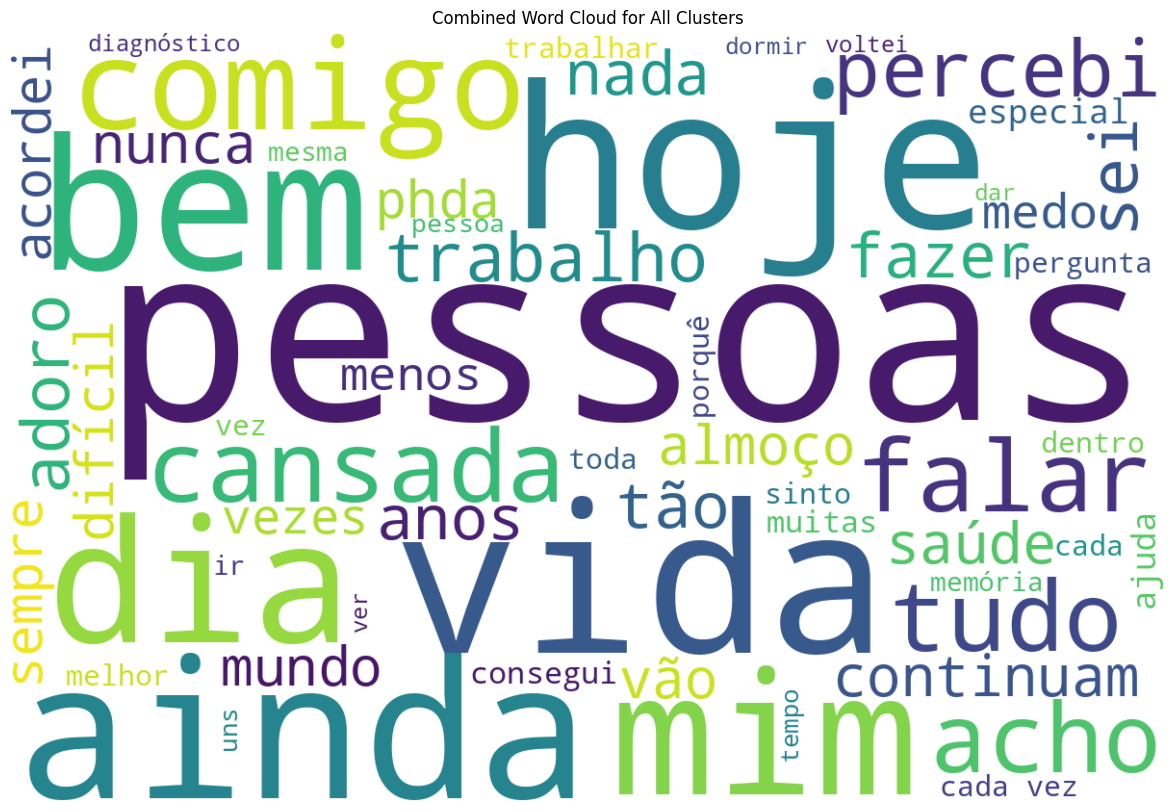

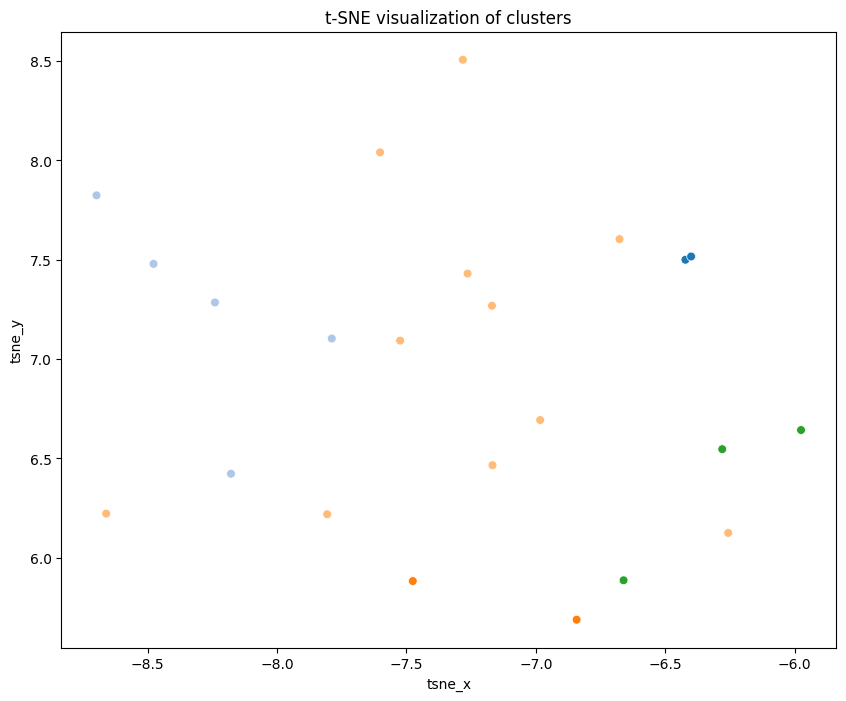

In [16]:
all_status_workflow(df_women_adhd, df_women_adhd, column, n_clusters=5)

DF shape: (137, 67)

Cluster 0:
['música', 'coisas', 'fazer', 'dia', 'ouvir', 'hoje', 'bem', 'casa', 'consigo', 'pessoas', 'gosto', 'faz', 'enquanto', 'sempre', 'sinto', 'anos', 'tanto', 'comigo', 'pessoa', 'mim']

Cluster 1:
['dia', 'fazer', 'gosto', 'sempre', 'bem', 'hoje', 'ver', 'tempo', 'coisas', 'sinto', 'sentir', 'trabalho', 'ir', 'melhor', 'algo', 'jogar', 'mim', 'anos', 'pessoas', 'casa']

Cluster 2:
['dia', 'algo', 'pessoas', 'sinto', 'hoje', 'sempre', 'fazer', 'casa', 'vida', 'ainda', 'tudo', 'gosto', 'melhor', 'agora', 'anos', 'vezes', 'mãe', 'mim', 'bem', 'acho']

Cluster 3:
['dia', 'fazer', 'hoje', 'algo', 'gosto', 'ainda', 'tempo', 'forma', 'ir', 'sempre', 'pai', 'coisas', 'ver', 'mim', 'apesar', 'bastante', 'vez', 'pessoas', 'conseguir', 'anos']

Cluster 4:
['tudo', 'dia', 'escrever', 'sempre', 'vezes', 'apenas', 'mim', 'pessoas', 'algo', 'filme', 'sinto', 'pessoa', 'nunca', 'agora', 'bem', 'mesma', 'vida', 'cabeça', 'pensar', 'coisas']


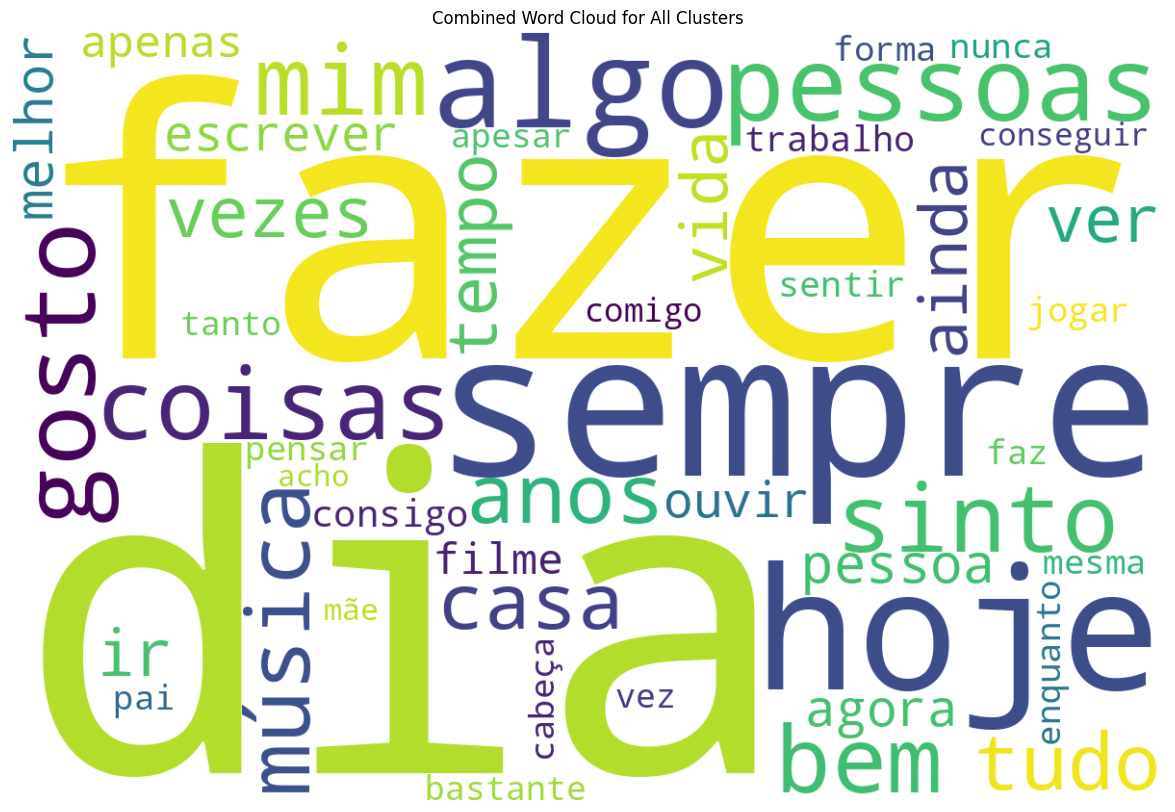

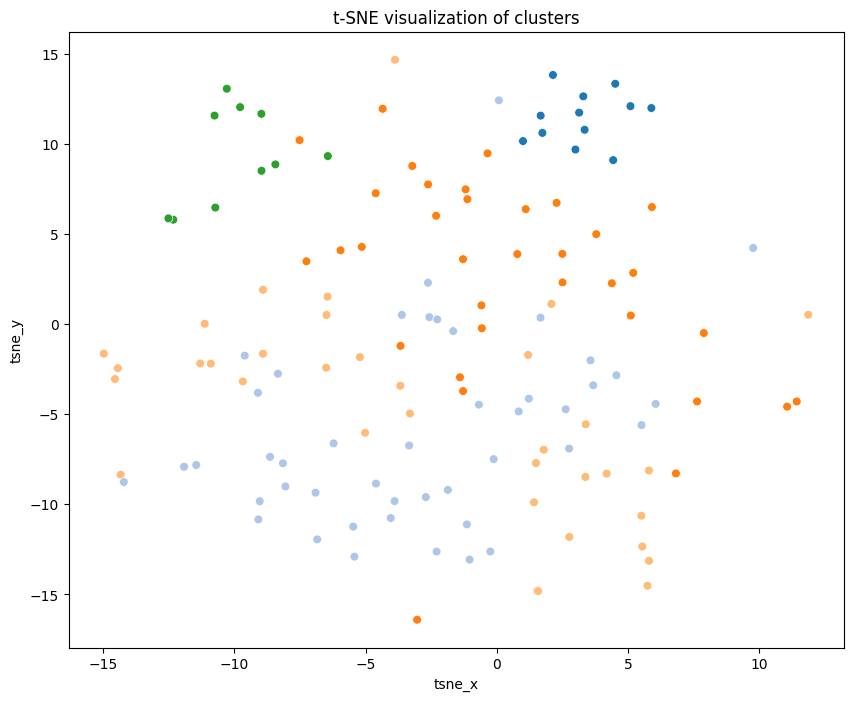

In [17]:
all_status_workflow(df_others, df_others, column, n_clusters=5)

## ADHD vs. Non-ADHD

In [18]:
mask_adhd = (df['adhd_diagnosis']=="Sim, diagnosticado")
mask_others = ~mask_adhd

df_adhd = df[mask_adhd]
df_others = df[mask_others]

DF shape: (33, 67)

Cluster 0:
['phda', 'momento', 'dizer', 'gosto', 'ainda', 'consigo', 'anos', 'apenas', 'cansada', 'correr', 'chamada', 'parece', 'causa', 'interesses', 'dois', 'enfim', 'diferente', 'outro', 'pensar', 'marcou']

Cluster 1:
['dia', 'ainda', 'fazer', 'hoje', 'bem', 'trabalhar', 'animais', 'sempre', 'mim', 'vida', 'acho', 'algo', 'tudo', 'tempo', 'apenas', 'uns', 'pessoas', 'coisas', 'consegui', 'interesse']

Cluster 2:
['percebi', 'phda', 'vida', 'adoro', 'tempo', 'menos', 'animais', 'cérebro', 'diagnóstico', 'sentir', 'mim', 'ainda', 'consegui', 'depressão', 'ajuda', 'algo', 'fazer', 'mesma', 'mundo', 'muitas']

Cluster 3:
['pessoas', 'vida', 'tudo', 'vezes', 'vez', 'trabalho', 'dia', 'sempre', 'falar', 'toda', 'mental', 'mim', 'memória', 'nada', 'estudo', 'posso', 'melhor', 'fazer', 'bem', 'sei']

Cluster 4:
['sinto', 'hoje', 'bem', 'dia', 'tudo', 'phda', 'acordei', 'uns', 'nada', 'pessoas', 'anos', 'vida', 'sempre', 'ainda', 'gosto', 'sei', 'difícil', 'trabalho', '

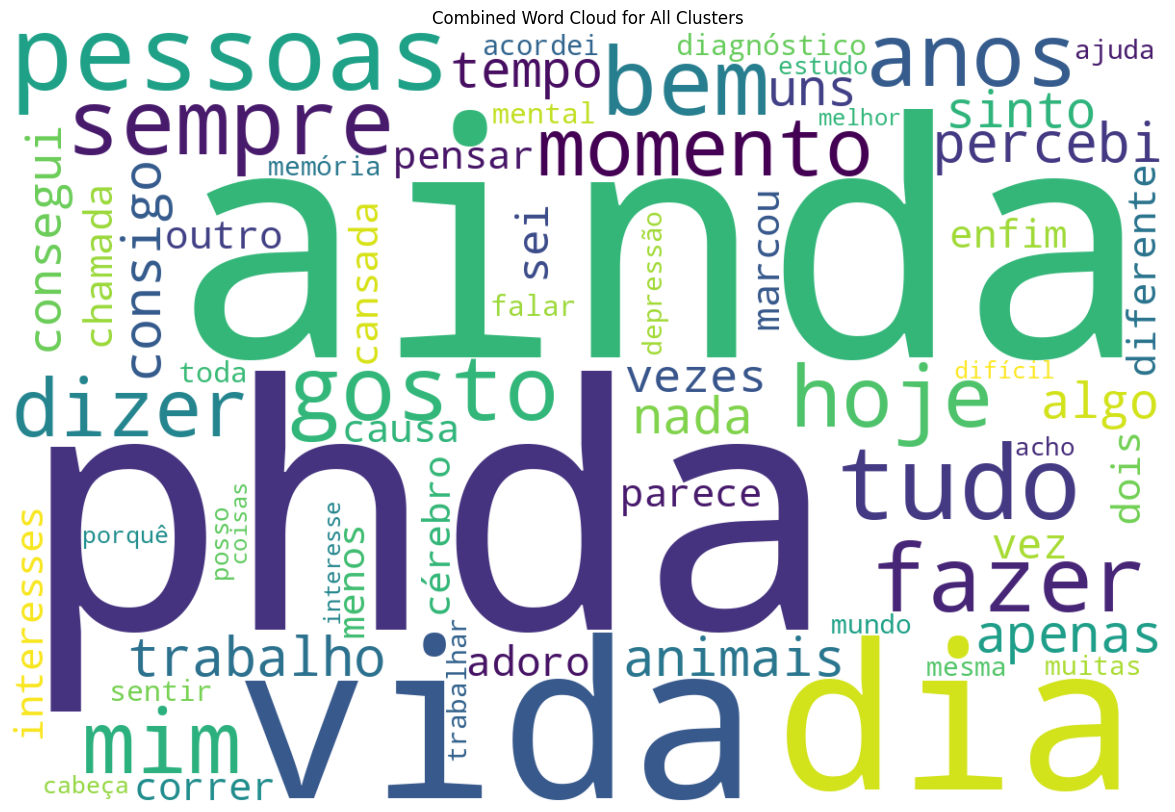

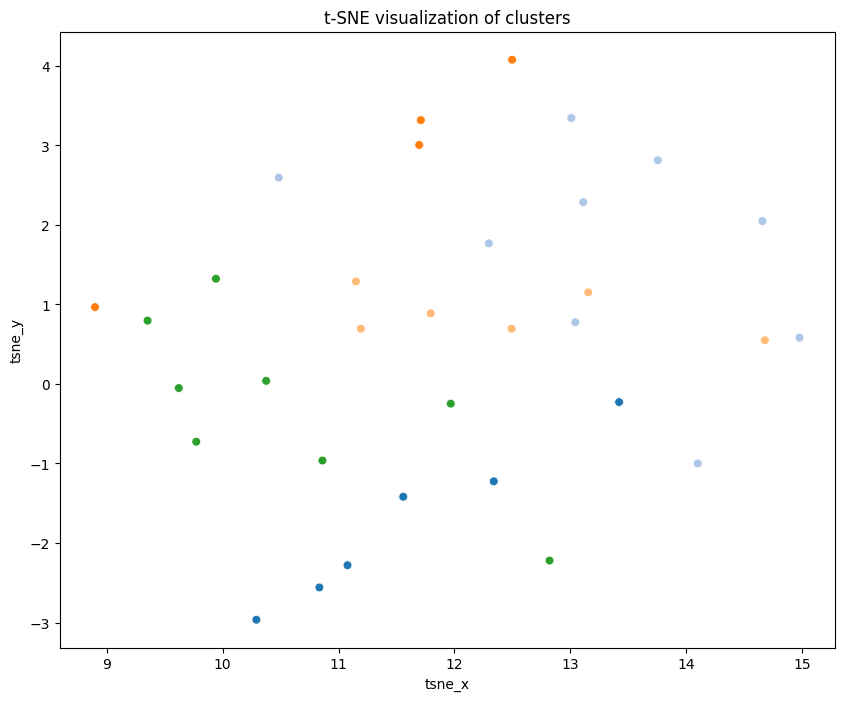

In [19]:
all_status_workflow(df_adhd, df_adhd, column)

DF shape: (127, 67)

Cluster 0:
['escrever', 'pessoas', 'tipo', 'gosto', 'vezes', 'sinto', 'mim', 'dia', 'confortável', 'acho', 'sempre', 'fazer', 'séries', 'sol', 'quero', 'chegar', 'vem', 'pensar', 'alguma', 'forma']

Cluster 1:
['dia', 'fazer', 'hoje', 'ir', 'algo', 'ainda', 'ver', 'sempre', 'bem', 'casa', 'coisas', 'tempo', 'manhã', 'tarde', 'melhor', 'lembro', 'nada', 'altura', 'dias', 'gosto']

Cluster 2:
['música', 'fazer', 'coisas', 'casa', 'hoje', 'dia', 'ouvir', 'sinto', 'sempre', 'anos', 'gosto', 'ainda', 'consigo', 'bem', 'mim', 'pessoas', 'trabalho', 'vida', 'tudo', 'outros']

Cluster 3:
['dia', 'fazer', 'gosto', 'algo', 'sempre', 'hoje', 'sinto', 'coisas', 'tempo', 'mim', 'durante', 'bem', 'vez', 'tarde', 'sentir', 'desporto', 'vezes', 'pessoas', 'anos', 'ver']

Cluster 4:
['dia', 'pai', 'algo', 'fazer', 'gosto', 'forma', 'pessoas', 'ainda', 'ler', 'hoje', 'tempo', 'pessoa', 'anos', 'ir', 'tudo', 'ver', 'perceber', 'sempre', 'coisas', 'bastante']


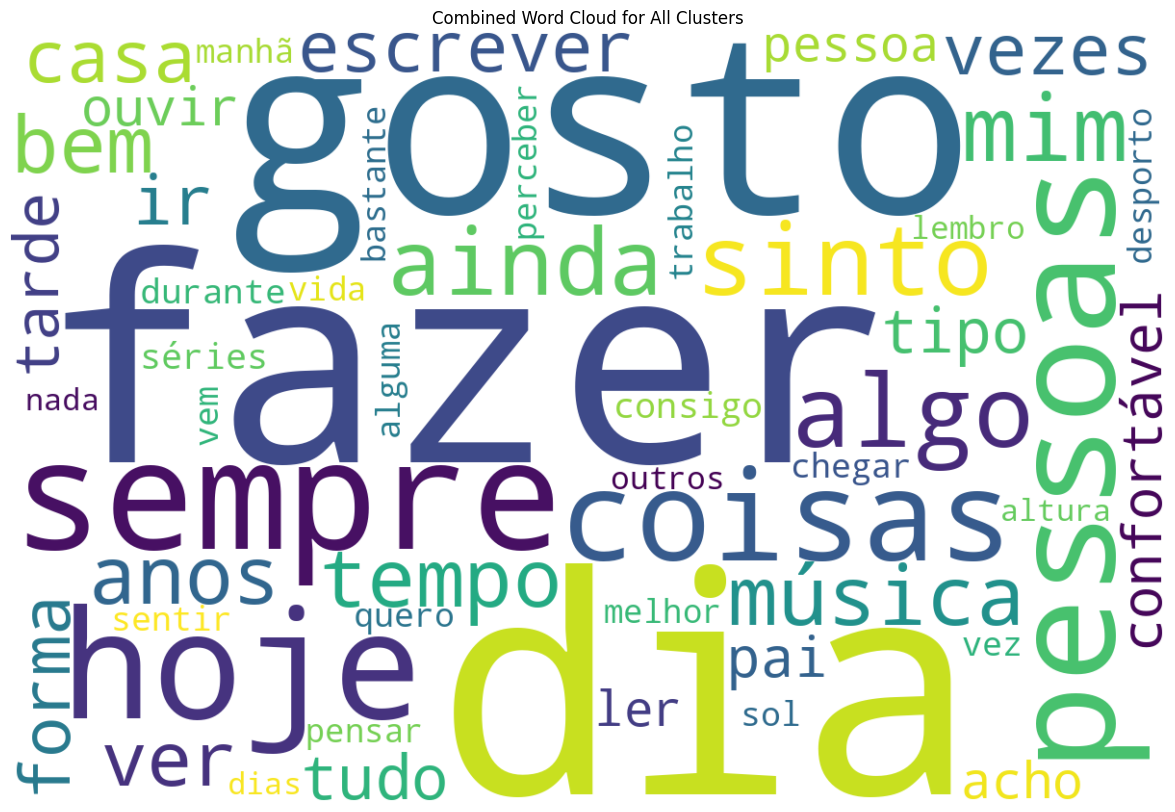

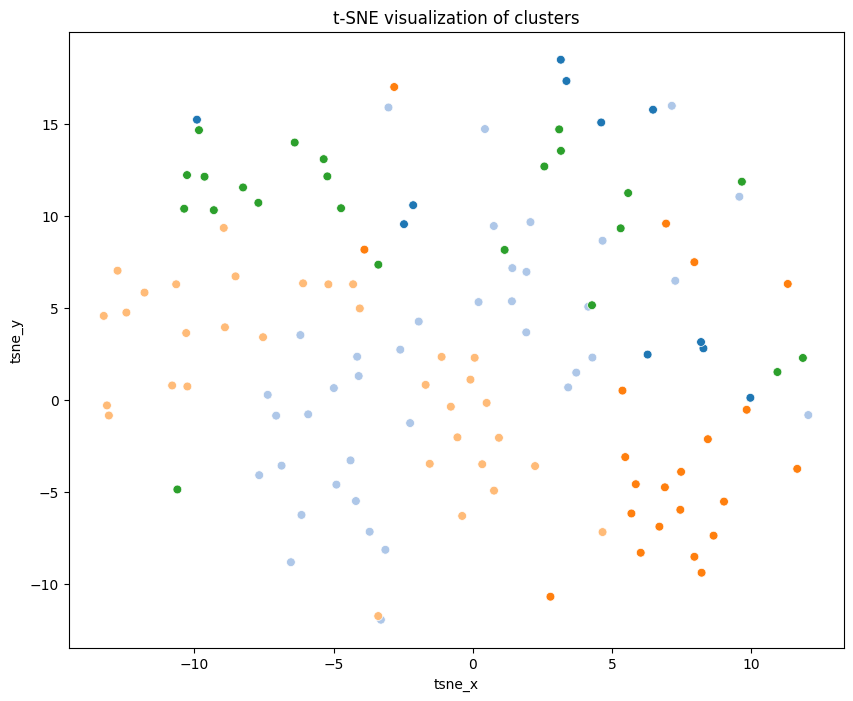

In [20]:
all_status_workflow(df_others, df_others, column)

## Women vs. Men

In [21]:
mask_women = (df['sex']=="Feminino")
mask_others = ~mask_women

df_women = df[mask_women]
df_others = df[mask_others]

DF shape: (99, 67)

Cluster 0:
['fazer', 'dia', 'hoje', 'pessoas', 'ainda', 'bem', 'mim', 'sempre', 'nunca', 'sinto', 'coisas', 'ver', 'memória', 'vida', 'anos', 'tudo', 'vezes', 'trabalho', 'gosto', 'algo']

Cluster 1:
['dia', 'fazer', 'ainda', 'forma', 'algo', 'gosto', 'ler', 'tudo', 'sempre', 'coisas', 'hoje', 'sei', 'mim', 'acho', 'pessoas', 'interesse', 'tempo', 'pessoa', 'melhor', 'pouco']

Cluster 2:
['dia', 'ainda', 'gosto', 'fazer', 'tempo', 'bem', 'sempre', 'interesse', 'sei', 'comigo', 'casa', 'acho', 'hoje', 'ir', 'algo', 'todos', 'coisas', 'nunca', 'bastante', 'anos']

Cluster 3:
['dia', 'pessoas', 'fazer', 'ver', 'talvez', 'mãe', 'vez', 'forma', 'vida', 'casa', 'atenção', 'eventualmente', 'tipo', 'medo', 'fiz', 'lisboa', 'parte', 'sol', 'conseguir', 'cabeça']

Cluster 4:
['gosto', 'dia', 'fazer', 'mim', 'tempo', 'sinto', 'durante', 'senti', 'momento', 'sentir', 'feliz', 'sol', 'hoje', 'vezes', 'bem', 'sempre', 'tarde', 'tudo', 'trabalho', 'consegui']


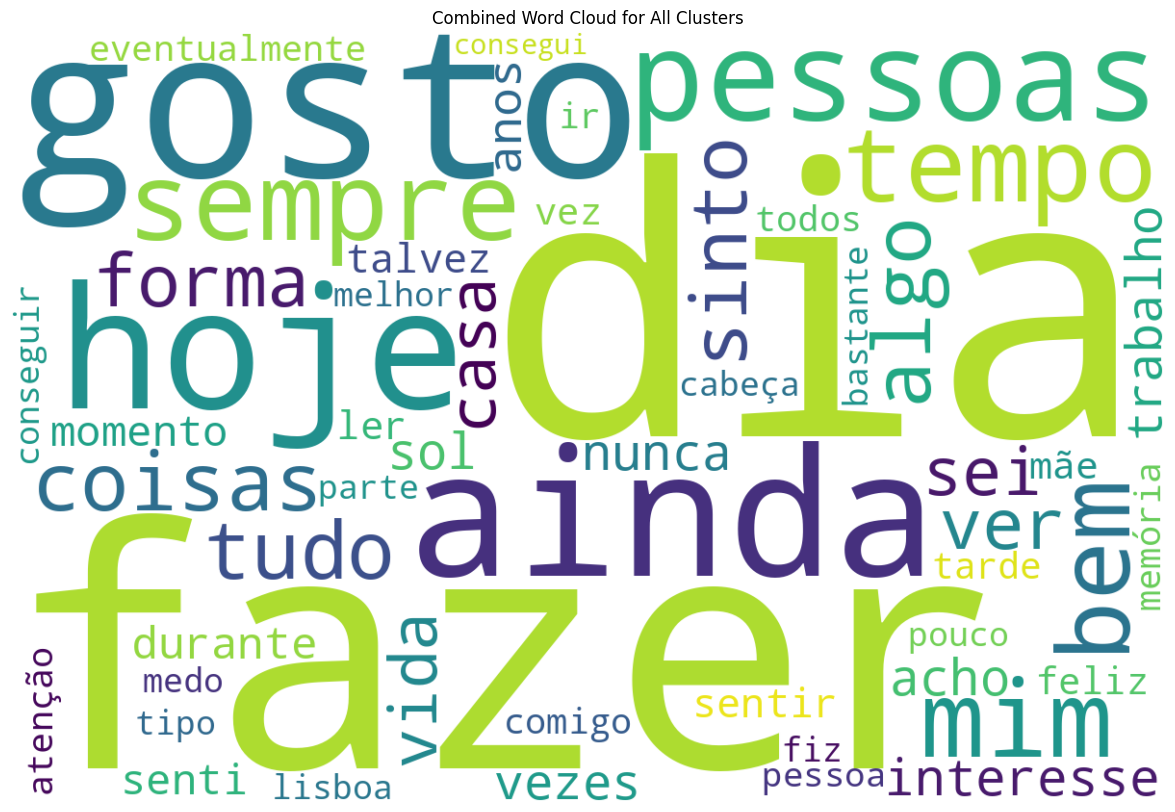

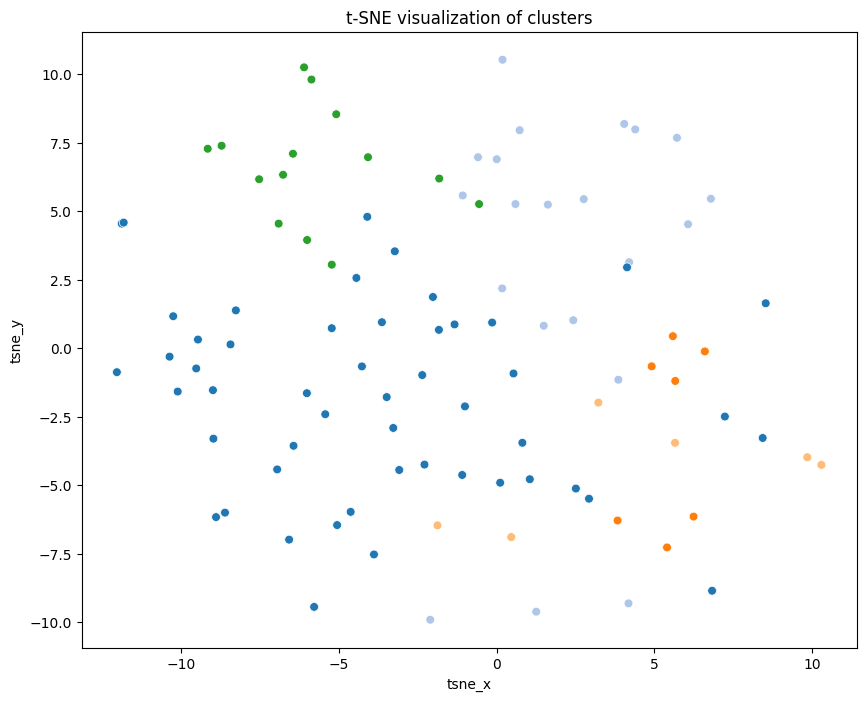

In [22]:
all_status_workflow(df_women, df_women, column)

DF shape: (61, 67)

Cluster 0:
['sempre', 'fazer', 'ver', 'coisas', 'acabar', 'faz', 'tempo', 'faculdade', 'faço', 'algo', 'dia', 'vezes', 'bastante', 'entanto', 'emoções', 'dormir', 'muitas', 'tentar', 'sentir', 'casa']

Cluster 1:
['hoje', 'dia', 'algo', 'gosto', 'ainda', 'tipo', 'apesar', 'fazer', 'coisas', 'jogo', 'sentir', 'bem', 'vez', 'ir', 'alguma', 'sempre', 'pessoas', 'tentar', 'vida', 'maneira']

Cluster 2:
['dia', 'fazer', 'hoje', 'melhor', 'jogar', 'qualquer', 'ir', 'algo', 'anos', 'sempre', 'amigos', 'gosto', 'senti', 'ainda', 'sinto', 'tarde', 'tempo', 'bem', 'casa', 'vida']

Cluster 3:
['algo', 'pai', 'tempo', 'dia', 'primeira', 'ir', 'forma', 'bastante', 'parte', 'hoje', 'jogos', 'acabar', 'conseguir', 'pessoa', 'ver', 'tentar', 'gosto', 'escrever', 'gostos', 'especial']

Cluster 4:
['pessoas', 'escrever', 'tudo', 'sinto', 'confortável', 'pensar', 'algo', 'estudo', 'tipo', 'algum', 'vida', 'bom', 'possam', 'sempre', 'dia', 'vez', 'pessoal', 'cada', 'super', 'vários']


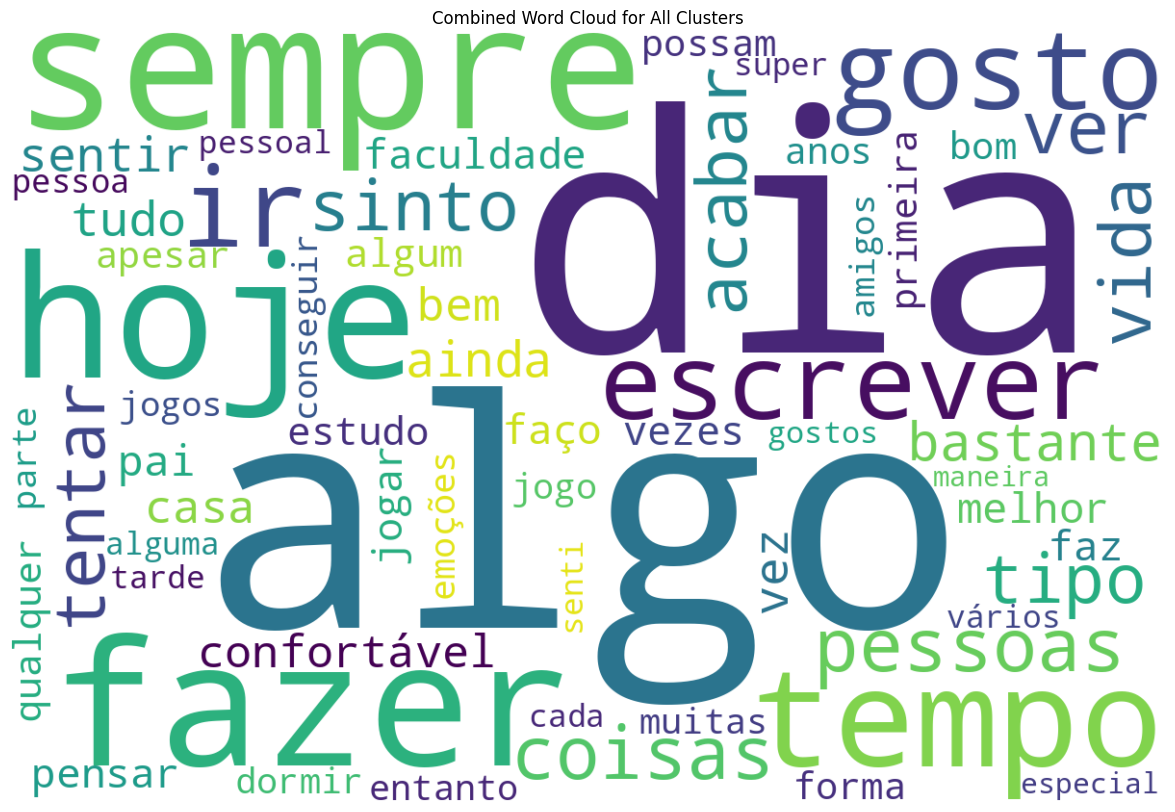

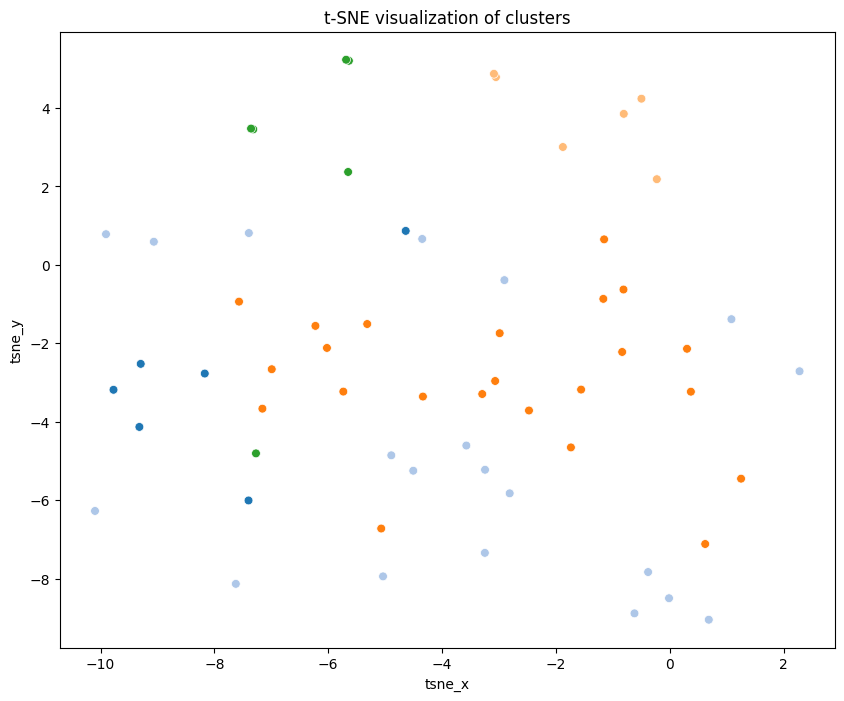

In [23]:
all_status_workflow(df_others, df_others, column)